# This notebook regenerate the SED according SNLS catalog

In [44]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline
from IPython.display import Image, display
from PIL import Image
from scipy.interpolate import interp1d

In [45]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [46]:
index_num=0
index_val=1
index_temp=2
index_logg=3
index_logz=4
index_spec=5

# Configuration

## Input files

### Input file containing the SED

In [47]:
#input_fits='sedgrid_pickle_uvi_selected.fits'
input_fits='sedgrid_pickle_uvk_selected.fits'

In [48]:
#input_model_tag='pickle_uvi'
input_model_tag='pickle_uvk'

### Input file containing the AB magnitudes

In [49]:
#input_sedmagcol="pickle_uvi_snlsmagcol_Noextinct.csv"
input_sedmagcol="pickle_uvk_snlsmagcol_Noextinct.csv"

### Input file containing the SNLS catalog and predicted SED Number

the output of **SelectLNereastNeighbourg**

In [50]:
#input_file_SNLS_pred='prediction_SNLS_pickle_uvi.csv'
input_file_SNLS_pred='prediction_SNLS_pickle_uvk.csv'

## Output file

In [51]:
#output_fits='regenerated_sedgrid_pickle_uvi.fits'
output_fits='regenerated_sedgrid_pickle_uvk.fits'

# Open input files

## Get result of SNLS catalog and SED number matching

In [52]:
df_snls=pd.read_csv(input_file_SNLS_pred, index_col=0)

In [53]:
df_snls.head()

,rag,decg,mxu,mxg,mxr,mxi,mxi2,mxz,data,u-g,g-r,r-i,i-z,sednum
0,36.385099,-4.996876,21.262462,19.131542,17.885551,16.976569,17.049769,16.583786,D1,2.130920,1.245991,0.908982,0.392783,129
1,36.532753,-4.996622,19.296211,18.510545,18.141572,17.993850,18.003495,17.936816,D1,0.785666,0.368973,0.147722,0.057034,14
2,36.093245,-4.992603,19.695154,17.795234,16.833046,16.417383,16.442505,16.220391,D1,1.899920,0.962188,0.415663,0.196992,43
3,36.473862,-4.992807,18.418090,17.413157,16.939017,16.754636,16.769276,16.675400,D1,1.004933,0.474140,0.184380,0.079237,58
4,36.546502,-4.994603,22.990037,20.823232,19.558416,18.027183,18.136777,17.385769,D1,2.166805,1.264816,1.531233,0.641415,113


In [54]:
NBOBJ=len(df_snls)

## Retrieve the SED 

In [55]:
hdul = fits.open(input_fits)

In [56]:
hdul.info()

Filename: sedgrid_pickle_uvk_selected.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   (8515, 132)   float64   


In [57]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                  132                                                  
NBSED   =                  131                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDMODEL= 'pickle_uvk'                                                          
IDX_SPEC=                    5                                                  
IDX_MAG =                 85

In [58]:
datain = hdul[0].data

In [59]:
datain.shape

(132, 8515)

In [60]:
NBCOL=datain.shape[1]
NBROW=datain.shape[0]

In [61]:
WL=datain[0,index_spec:]

In [62]:
# wavelength definitions
WLMIN=WL.min() # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=WL.max() # Minimum wavelength : PySynPhot works with Angstrom
NBWLBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
WLBinWidth=(WLMAX-WLMIN)/float(NBWLBINS) # Bin width in Angstrom

## Get SED magnitudes

In [63]:
df_sed=pd.read_csv(input_sedmagcol, index_col=0)

In [64]:
df_sed.head()

,idxcat,u,g,r,i,z,u-g,g-r,r-i,i-z
0,1,3.126320,0.628382,-0.515951,-1.342848,-1.723940,2.497938,1.144332,0.826897,0.381093
1,2,0.741058,0.071886,-0.010904,0.008176,0.082443,0.669172,0.082790,-0.019080,-0.074267
2,3,0.043637,-0.149839,0.164380,0.429206,0.560733,0.193476,-0.314220,-0.264826,-0.131527
3,4,1.991587,0.409862,-0.330504,-0.597644,-0.736793,1.581725,0.740366,0.267140,0.139149
4,5,3.168154,0.600348,-0.440627,-0.854787,-1.063724,2.567806,1.040975,0.414160,0.208937


In [65]:
df_sed.iloc[46,:]["g"]

0.5975727133568398

In [66]:
df_sed.loc[46,"g"]

0.5975727133568398

In [67]:
df_snls.iloc[0,:]["sednum"]

129

# Create output

## Reserve space

In [68]:
data=np.zeros((NBOBJ+1,NBCOL))

In [69]:
data[0,index_spec:]=WL

## Fills new SED

In [70]:
dataset_to_num={"D1":1,"D2":2,"D3":3,"D4":4}

In [71]:
for idx in np.arange(NBOBJ):
    sed_idx=df_snls.iloc[idx,:]["sednum"]  # extract from catalog the id of nearest SED
    sed_gmag=df_sed.iloc[sed_idx,:]["g"]   # extract G-magnitude of that SED
    snls_gmag=df_snls.iloc[idx,:]["mxg"]   # extract G-magnitude in the SNLS catalog
    dataset=df_snls.iloc[idx,:]["data"]    # extract the dataset name in the SNLS catalog
    datasetnum=dataset_to_num[dataset]     # convert the dataset name in a number
    delta_m=snls_gmag-sed_gmag             # calculate magnitude difference
    factor=np.power(10,-0.4*delta_m)       #calculate amplitude factor to multiply the SED flux
    #print 'snls_idx = ',idx, ' ,sed_idx=',sed_idx, ' ,mag_sed=',sed_gmag,' ,mag_snls=',snls_gmag, ' ,factor=',factor, 'data=',datasetnum
    data[idx+1,index_spec:]=datain[sed_idx+1,index_spec:]*factor   # multiply the SED by the factor
    data[idx+1,index_val]=datain[sed_idx+1,index_val]              # save the validity index 
    data[idx+1,index_temp]=sed_idx                               # save the reference sed idx
    data[idx+1,index_logg]=datasetnum                            # save the SNLS catalog number
    data[idx+1,index_num]=idx                                     # save the SNLS obj number

## Plot new SED

In [72]:
VMIN=data[1:,index_spec:].min()
VMAX=data[1:,index_spec:].max()

In [73]:
VMIN,VMAX

(0.0, 2.3841929049607235e-15)

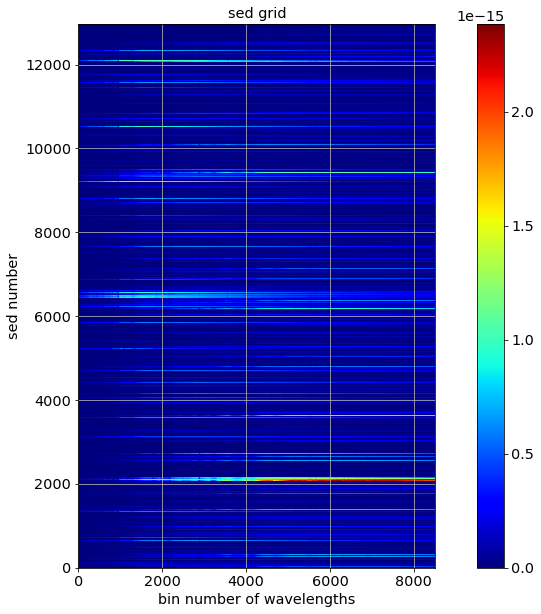

In [74]:
plt.figure(figsize=(15,10))    
img=plt.imshow(data[1:,index_spec:],origin='lower',vmin=VMIN,vmax=VMAX,cmap='jet')
plt.colorbar(img)
plt.grid(True)
plt.title('sed grid')
plt.xlabel('bin number of wavelengths')
plt.ylabel('sed number')
plt.show()

Text(0,0.5,u'sed (flam)')

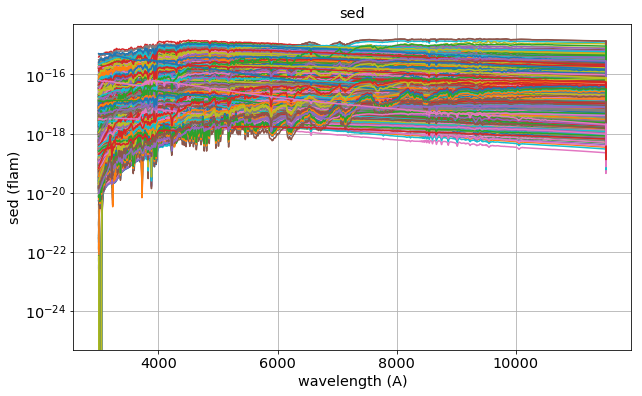

In [75]:
for idx in np.arange(NBOBJ):
    if not idx%10:
        plt.semilogy(WL,data[idx+1,index_spec:])
plt.grid()
plt.title('sed')
plt.xlabel('wavelength (A)')
plt.ylabel('sed (flam)')

# SAVE in a fits file

In [76]:
# save SED in a fits file    
hdr = fits.Header()
hdr['NBSED'] = NBOBJ
hdr['NBWLBIN']=NBWLBINS
hdr['WLMIN']=WLMIN
hdr['WLMAX']=WLMAX
hdr['WLBINWDT']=WLBinWidth
hdr['SEDUNIT']='FLAM'  
    
hdr['SEDMODEL'] = input_model_tag

hdr['IDX_NUM']=index_num
hdr['IDX_VAL']=index_val
hdr['IDX_SED']=index_temp
hdr['IDX_DATA']=index_logg
hdr['IDX_SPEC']=index_spec
       
print hdr
    
hdu = fits.PrimaryHDU(data,header=hdr)
hdu.writeto(output_fits,overwrite=True)

NBSED   =                12962                                                  NBWLBIN =                 8510                                                  WLMIN   =               3000.0                                                  WLMAX   =              11510.0                                                  WLBINWDT=                  1.0                                                  SEDUNIT = 'FLAM    '                                                            SEDMODEL= 'pickle_uvk'                                                          IDX_NUM =                    0                                                  IDX_VAL =                    1                                                  IDX_SED =                    2                                                  IDX_DATA=                    3                                                  IDX_SPEC=                    5                                                  END                                     

In [77]:
ls -l *.fits

-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine   883042560 Jul  6 15:09 regenerated_sedgrid_pickle_uvi.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine   883042560 Jul  6 15:14 regenerated_sedgrid_pickle_uvk.fits
-rw-r--r--@ 1 dagoret  LAL\Utilisateurs du domaine  1031195520 Mar 26 19:42 sedgrid_phoenixmodels.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine  1414071360 Jul  6 14:45 sedgrid_phoenixmodels_all.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine  1237423680 Mar 28 14:42 sedgrid_phoenixmodels_extinct_03.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine  1237423680 Mar 28 15:22 sedgrid_phoenixmodels_extinct_10.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine  1237423680 Mar 28 16:07 sedgrid_phoenixmodels_extinct_50.fits
-rw-r--r--@ 1 dagoret  LAL\Utilisateurs du domaine  1237423680 Mar 27 10:20 sedgrid_phoenixmodels_good.fits
-rw-r--r--  1 dagoret  LAL\Utilisateurs du domaine    64108800 Jul  6 14:45 sedgrid_phoenixmodels_selected1000.fits
